# 1. Prelimitary

In [15]:
import numpy as np
import random
from project_utils import load_train_set, load_test_set, hint

random.seed()
np.random.seed()

TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

hint("Loading train set...")
train = load_train_set(TRAIN_PATH)

hint("Loading test set...")
test = load_test_set(TEST_PATH)

hint("Done!")

Done!


# 2. Preprocessing

## 2.1 Standarization

In [16]:
from skimage.color import rgb2gray
from skimage.transform import resize

IMAGE_DIM = (256, 256)
INVERSE_THRESHOLD = 0.3

def standardize_images(img_list, shape=IMAGE_DIM, inverse_threshold=INVERSE_THRESHOLD):
    """make grayscale, resize, and remove light background"""
    to_return = [np.expand_dims(rgb2gray(img), axis=-1) for img in img_list]
    to_return = [resize(img, shape) for img in to_return]
    for i, img in enumerate(to_return):
        if np.mean(img) > inverse_threshold:
            to_return[i] = 1 - img
    return np.array(to_return)

def standardize_masks(mask_list, shape=IMAGE_DIM):
    """make grayscale and resize"""
    to_return = [np.expand_dims(mask, axis=-1) for mask in mask_list]
    to_return = [resize(mask, shape) for mask in to_return]
    return np.array(to_return, dtype=np.bool)

In [17]:
hint("Working on X...")
X = standardize_images(train['image'])
hint("Working on Y...")
Y = standardize_masks(train['mask'])
hint("Working on X_...")
X_ = standardize_images(test['image'])
hint("Done!")

Done!


## 2.2 Data Augmentation

In [18]:
import numpy as np
# from scipy.ndimage.interpolation import map_coordinates
# from scipy.ndimage.filters import gaussian_filter

##! This method creates holes in the masks and black gaps near the borders
# def elastic_transform(image, mask, alpha, sigma, random_state=None):
#     """
#     Elastic deformation of images as described in "Best Practices for
#     Convolutional Neural Networks applied to Visual Document Analysis"
#     (Simard, Steinkraus and Platt)
       
#     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
#     """
#     if random_state is None:
#         random_state = np.random.RandomState(None)

#     shape = image.shape
#     dx = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode="constant", cval=0)*alpha
#     dy = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode="constant", cval=0)*alpha

#     x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
#     indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
#     return (
#         map_coordinates(image, indices, order=1).reshape(shape),
#         map_coordinates(mask, indices, order=1).reshape(shape)
#     )

def augment_data(X, Y):
    """
    Add augmented data to a copy of the original data
    
    method currently using: rotate 180
    
    :return: a new array containing the original and the augmented data
    """
    X_, Y_ = X, Y

    X_ = np.append(X_, np.flip(np.flip(X, axis=1), axis=2), axis=0)
    Y_ = np.append(Y_, np.flip(np.flip(Y, axis=1), axis=2), axis=0)

    return X_, Y_

In [19]:
X, Y = augment_data(X, Y)
print("%d samples added (total %d)" % (X.shape[0]-train.shape[0], X.shape[0]))

670 samples added (total 1340)


In [20]:
from sklearn.utils import shuffle

X, Y = shuffle(X, Y)

# 3. Model

In [27]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam

CONV_BASE_SIZE = 32
CONV_KERNEL = (3, 3)
TRAN_KERNEL = (3, 3)
CONV_ACTIVATION = 'relu'
CONV_PADDING = 'same'
CONV_KERNEL_INIT = 'he_normal'
CONV_DROPOUT = 0.2
POOLING_SIZE = (2, 2)
OPTIMIZER = 'adam'

def build_conv_layer(filter_size):
    """
    build a convolution layer using the preset hyperparameters
    """
    return Conv2D(
        filter_size, 
        kernel_size=CONV_KERNEL,
        padding=CONV_PADDING,
        activation=CONV_ACTIVATION,
        kernel_initializer=CONV_KERNEL_INIT
    )

def build_conv_block(connect, depth):
    """
    build a 2-convolutional-layer block
    """
    filter_size = CONV_BASE_SIZE*(2**depth)
    x = build_conv_layer(filter_size)(connect)
    x = Dropout(CONV_DROPOUT)(x)
    x = build_conv_layer(filter_size)(x)
    return x

def build_upsample_block(connect, merge, depth):
    """
    build a upsampling block
    """
    filter_size = CONV_BASE_SIZE*(2**depth)
    x = Conv2DTranspose(
        filter_size, 
        TRAN_KERNEL, 
        strides=POOLING_SIZE, 
        padding=CONV_PADDING
    )(connect)
    return concatenate([x, merge])

In [28]:
def get_model():
    # input layer
    inputs = Input((IMAGE_DIM + (1,)))

    # downsampling layers (left of the U)
    down_conv_0 = build_conv_block(inputs, depth=0)
    down_pool_0 = MaxPooling2D(POOLING_SIZE)(down_conv_0)
    down_conv_1 = build_conv_block(down_pool_0, depth=1)
    down_pool_1 = MaxPooling2D(POOLING_SIZE)(down_conv_1)
    down_conv_2 = build_conv_block(down_pool_1, depth=2)
    down_pool_2 = MaxPooling2D(POOLING_SIZE)(down_conv_2)
    down_conv_3 = build_conv_block(down_pool_2, depth=3)
    down_pool_3 = MaxPooling2D(POOLING_SIZE)(down_conv_3)

    # bottom layer
    conv_bottom = build_conv_block(down_pool_3, depth=4)

    # upsampling layers (right of the U)
    upsample_3 = build_upsample_block(conv_bottom, down_conv_3, 3)
    up_conv_3 = build_conv_block(upsample_3, depth=3)
    upsample_2= build_upsample_block(up_conv_3, down_conv_2, 2)
    up_conv_2= build_conv_block(upsample_2, depth=2)
    upsample_1= build_upsample_block(up_conv_2, down_conv_1, 1)
    up_conv_1= build_conv_block(upsample_1, depth=1)
    upsample_0= build_upsample_block(up_conv_1, down_conv_0, 0)
    up_conv_0= build_conv_block(upsample_0, depth=0)

    # output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up_conv_0)

    # compile
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=OPTIMIZER, 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

## 4. Fitting (K-Fold)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold

BATCH_SIZE = 16
EPOCHS = 50
K = 10
BEST_MODEL_FILENAMES = [
    'checkpoints/dsb2018-unet-benchmark-k%d-checkpoint.h5' % (d)
    for d in range(K)
]

history = []
kfold = KFold(n_splits=K)
for i, (tr, va) in enumerate(kfold.split(X, y=Y)):
    hint("Working on fold %d/%d" % (i+1, K))
    model = get_model()
    checkpoint = ModelCheckpoint(BEST_MODEL_FILENAMES[i], save_best_only=True)
    history.append(model.fit(
        X[tr], Y[tr], 
        validation_data=(X[va], Y[va]),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        callbacks=[checkpoint],
        verbose=2
    ))

Working on fold 5/5
Train on 1072 samples, validate on 268 samples
Epoch 1/50
 - 13s - loss: 0.4256 - acc: 0.8404 - val_loss: 0.3034 - val_acc: 0.8644
Epoch 2/50
 - 11s - loss: 0.2724 - acc: 0.8703 - val_loss: 0.2634 - val_acc: 0.8708
Epoch 3/50
 - 11s - loss: 0.1979 - acc: 0.9139 - val_loss: 0.1560 - val_acc: 0.9396
Epoch 4/50
 - 11s - loss: 0.1216 - acc: 0.9542 - val_loss: 0.1042 - val_acc: 0.9587
Epoch 5/50
 - 11s - loss: 0.1072 - acc: 0.9591 - val_loss: 0.0894 - val_acc: 0.9651
Epoch 6/50
 - 11s - loss: 0.0876 - acc: 0.9650 - val_loss: 0.0805 - val_acc: 0.9680
Epoch 7/50
 - 11s - loss: 0.0879 - acc: 0.9652 - val_loss: 0.0884 - val_acc: 0.9665
Epoch 8/50
 - 11s - loss: 0.0841 - acc: 0.9666 - val_loss: 0.0832 - val_acc: 0.9665
Epoch 9/50
 - 11s - loss: 0.0823 - acc: 0.9668 - val_loss: 0.0757 - val_acc: 0.9704
Epoch 10/50
 - 10s - loss: 0.0784 - acc: 0.9681 - val_loss: 0.0799 - val_acc: 0.9683
Epoch 11/50
 - 10s - loss: 0.0761 - acc: 0.9690 - val_loss: 0.0717 - val_acc: 0.9719
Epoch 1

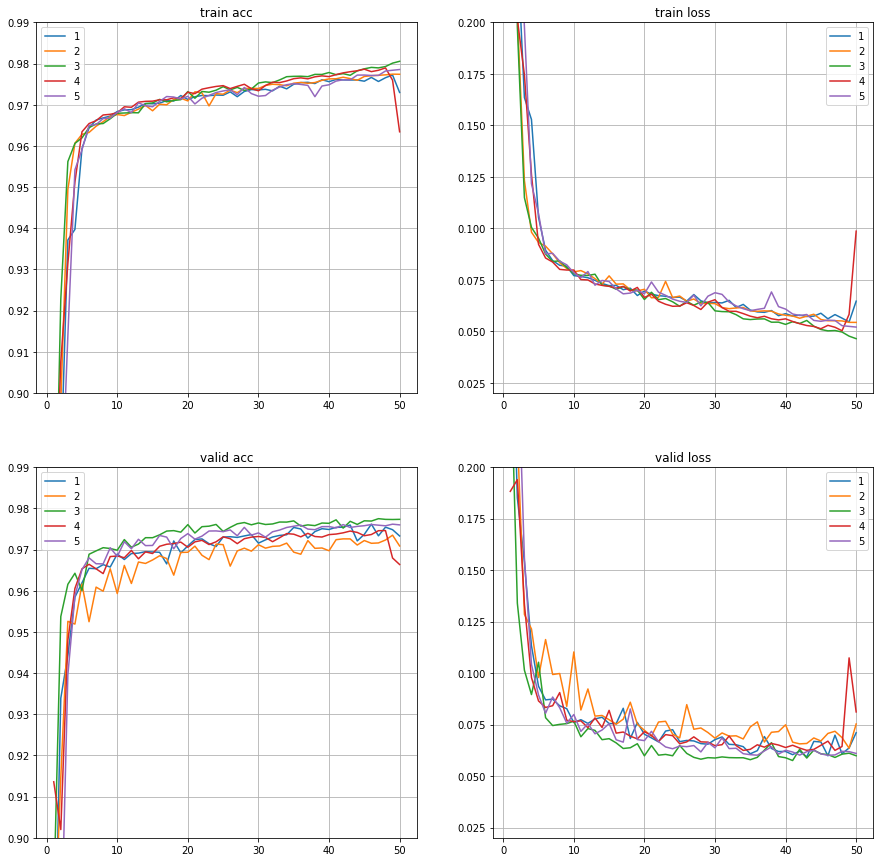

In [30]:
import matplotlib.pyplot as plt

_, axis = plt.subplots(2, 2, figsize=(15, 15))
x_axis = range(1, EPOCHS+1)
for i, h in enumerate(history):
    l = i + 1
    axis[0, 0].plot(x_axis, h.history['acc'], label=l)
    axis[0, 1].plot(x_axis, h.history['loss'], label=l)
    axis[1, 0].plot(x_axis, h.history['val_acc'], label=l)
    axis[1, 1].plot(x_axis, h.history['val_loss'], label=l)
axis[0, 0].set_title('train acc')
axis[0, 0].set_ylim(0.9, 0.99)
axis[0, 1].set_title('train loss')
axis[0, 1].set_ylim(0.02, 0.2)
axis[1, 0].set_title('valid acc')
axis[1, 0].set_ylim(0.9, 0.99)
axis[1, 1].set_title('valid loss')
axis[1, 1].set_ylim(0.02, 0.2)
for r in range(2):
    for c in range(2):
        axis[r, c].legend()
        axis[r, c].grid(True)
plt.show()

# 5. Submission

In [34]:
from keras.models import load_model

pred_shape = (X_.shape[0],) + IMAGE_DIM + (1,)
pred = np.zeros(pred_shape)

for bm in BEST_MODEL_FILENAMES:
    model = load_model(bm)
    pred += model.predict(X_)
    del model

pred /= K

In [35]:
from project_utils import format_prediction, make_submittable

PREDICTION_THRESHOLD = 0.5

Y_ = format_prediction(
    pred, 
    original = test['image'],
    reduce_dimension=True
)

file_name = make_submittable(test['id'], Y_, title='benchmark')
print("Submittable file saved as \"%s\"" % file_name)

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Submittable file saved as "submission/benchmark_20180331-014729.csv"
